In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import pickle

from PIL import ImageFont
from PIL import ImageDraw 

from os import listdir
from os.path import isfile, join

In [2]:

def binarize_image(img):
    toReturn = img
    imgUndestorted = cv2.undistort(img, mtx, dist, None, mtx)
    

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(imgUndestorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    toReturn = combined_binary 
    return toReturn



def LanesStartingPoint(img):
    binary_warped = img 
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
   
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base,rightx_base

def GetLineIndicators(img, leftx_base, rightx_base, margin):
    binary_warped = img
    # Choose the number of sliding windows
    nwindows =10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
   
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []



    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return nonzero, left_lane_inds ,right_lane_inds

def FitPolynomials(nonzero, left_lane_inds, right_lane_inds):
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    leftLane  = [left_fit, leftx, lefty]
    rightLane = [right_fit, rightx, righty]
    return leftLane ,rightLane
  

In [3]:
calPickle = open ('calib.p', 'rb')
ret, mtx, dist, rvecs, tvecs = pickle.load( calPickle)
print (ret)
print(mtx)
calPickle.close()

ptransPickle = open ('pTrans.p', 'rb')
M, img_size, srcTrans, dstTrans = pickle.load( ptransPickle)




srcOverlay = np.float32(
    [  [690 ,450],
       [1100 ,700],               
       [320 , 700 ],
       [595 , 450]
    ]
    )

dstOverlay = np.float32(
    [  [1100 , 50  ],
       [1100 , 700 ],               
       [250 , 700 ],
       [250 , 50  ]
     
    ]
    )


Minv = cv2.getPerspectiveTransform( dstOverlay,srcOverlay,)


0.6101385536433866
[[  1.00391208e+03   0.00000000e+00   6.30724865e+02]
 [  0.00000000e+00   1.08034061e+03   3.52424736e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [4]:
# %load clsLine

class Line():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
         
         # x values of the fit of the line
        self.xfitted = []     
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
         
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
    
        
    
    def SanityCheck(self):
        
        
        
        if (self.radius_of_curvature[0]   == 0 or  self.radius_of_curvature[1]   ==  0 ):
            #print ('Failed Curvature - all zero')
            return 0
        
        if (self.radius_of_curvature[0]   < 1 and  self.radius_of_curvature[1]   < 1 ):
            #print ('Failed Curvature - less than 1')
            return 0
        
        # check for 'relavtive parallel'
        if (0.5 > self.radius_of_curvature[0]/(1.0 *self.radius_of_curvature[1])  or self.radius_of_curvature[0]/(1.0 *self.radius_of_curvature[1])  > 5  ):
            #print ('Failed Curvature - very different')
            return 0
        
        
        #distance in meters of vehicle center from the line
        if (self.line_base_pos > 4):
            #print ('Failed  - Center not Found')
            return 0
        
        
        return 1
        
class LineTracking():
    resultsMax  = 10
    resultsLength = 710 # hard coded number of results per lane 
                        # 710 measurements along Y axis to get X values
    def __init__(self):
        #average x values of the fitted line over the last n iterations
        self.bestx = None 

        # x values of the last n fits of the line
        self.recent_xfitted = [] 

        self.recent_lines =[]
        #polynomial coefficients over the last n iterations
        self.recent_polyCoef = None     
        
        #polynomial coefficients avg over the last n iterations
        self.average_polyCoef = None     

        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
    
 
            
    
    def AddLine(self,aLine):
        
        self.recent_xfitted.append(aLine.xfitted)
        lineCount = len(self.recent_xfitted)
        if (lineCount > self.resultsMax):
            del self.recent_xfitted[-1:]
            
        self.recent_lines.append(aLine)
        lineCount = len(self.recent_lines)
        if (lineCount > self.resultsMax):
            del self.recent_lines[-1:]
        
        

In [5]:



def processImage(img):
    global lineStats
    global linesFound    
    global lineStatsFound
    
    height, width = img.shape[:2]
    combined_binary = binarize_image(img)
    leftx_base,rightx_base = LanesStartingPoint(combined_binary)

    # projec the image orthogonal above view
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
   
    # Staring Points for Left and Right lanes
    leftx_base , rightx_base = LanesStartingPoint(binary_warped)
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Get Line Indicators
    nonezero, left_lane_inds, right_lane_inds = GetLineIndicators (binary_warped,leftx_base , rightx_base,margin)
     
    # Fit a second order polynomial to each
    leftLane, rightLane                       = FitPolynomials (nonezero, left_lane_inds, right_lane_inds)
    left_fit  =  leftLane[0]
    right_fit =  rightLane[0]
    leftx =   leftLane[1]
    lefty =   leftLane[2]
    rightx =   rightLane[1]
    righty =   rightLane[2]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval =np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / (2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / (2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Create an image to draw the lines on                 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    area = np.array([pts[0]],np.int32)
    cv2.fillPoly(color_warp, np.int_([area]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    
   
    '''
    COLLECT DATA
    '''
    
    
    aLine = Line()
    aLine.current_fit =[left_fit, right_fit] 
    aLine.radius_of_curvature = [left_curverad, right_curverad]
    
    #add x fited for the current frame
    aLine.xfitted = [left_fitx, right_fitx]
    
    #aLine.AddXValues([left_fitx,right_fitx])    
    aLine.allx = [leftx, rightx]    
    aLine.ally = [lefty, righty]
    
    centerPoint = int((leftx_base + rightx_base)/2)    
    aLine.line_base_pos  = abs(width/2 - centerPoint)*xm_per_pix 
    
    sanityCheck = aLine.SanityCheck()
    

    
    if (sanityCheck):
        aLine.detected = True
        lineStatsFound +=1
     
    lineStats = lineStats +1
    #if (lineStats%20 ==0 ):
    #    print ("Detect: ", aLine.detected)
        
    
   
    linesFound.AddLine(aLine)    
    
    '''
    MAP
    '''
    
    rL = 0 
    rR = 0 
    validR = 0 
    rSmooth = 0 
    smoothFactor = 0.9
    
    if (aLine.detected):
        rSmooth = smoothFactor * (left_curverad + right_curverad)/2
    
    for l in range(len(linesFound.recent_lines)):
        smoothFactor *=(1-smoothFactor)
        if (linesFound.recent_lines[l].detected):
            rL += linesFound.recent_lines[l].radius_of_curvature[0]
            rR += linesFound.recent_lines[l].radius_of_curvature[1]
            rSmooth += smoothFactor * (left_curverad + right_curverad)/2
            validR +=1
    
    rToShow = int((left_curverad + right_curverad)/2)
    if (validR > 0 ):
        rToShow = int(rSmooth)
        
        
    
    
        
    strTurn = ""    
    if (rToShow < 0):
        strTurn = "Left"
    else:
        strTurn = "Right"
    if (abs(rToShow)>8000):
        strTurn = "Straight"
        
        
    strRadius          = "Radius     : {:7d} meters. Orient:  {:>8}".format(rToShow, strTurn)
    strBaseCenterPoint = "Center Line: {:=8.1f} meters".format(aLine.line_base_pos)
    
    cv2.putText(newwarp,strRadius,(100,100), font, 1,(255,255,255),2)    
    cv2.putText(newwarp,strBaseCenterPoint,(100,130), font, 1,(255,255,255),2) 
        
    
    
    
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
                 

 Line Stats  0
 Line Stats  1


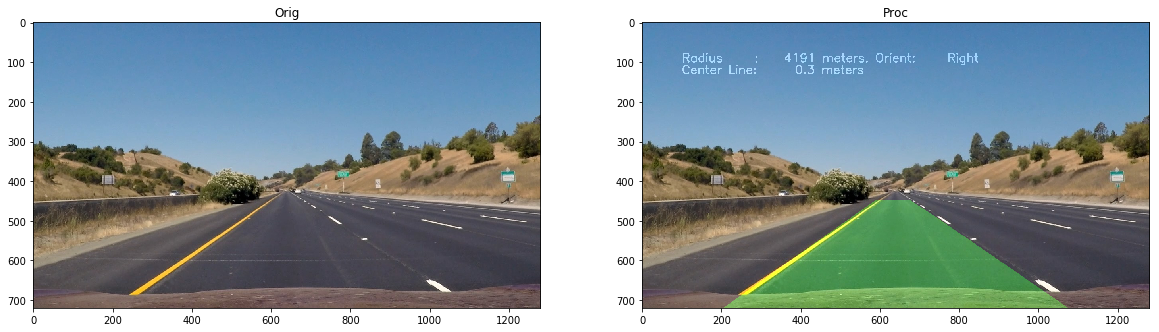

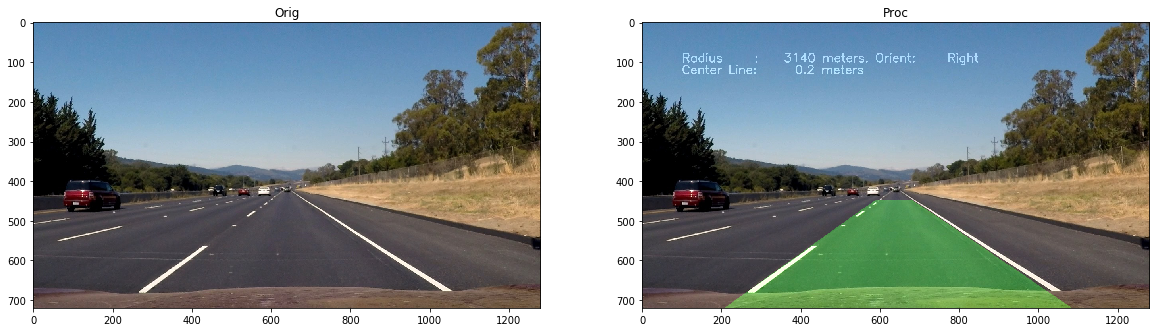

In [6]:
lineStats = 0 
lineStatsFound = 0

testImageDir = 'C:\_projects\selfDrivingCar\CarND-Advanced-Lane-Lines\\test_images'
testFiles = [f for f in listdir(testImageDir) if isfile(join(testImageDir, f))]
#for i in range(0,len(testFiles)-1):
linesFound = LineTracking()
for i in range(0,2):
    print (" Line Stats ", lineStats)
    fullFileName = testImageDir + '\\' + testFiles[i]
    #print (fullFileName)
    imgOriginal = mpimg.imread(fullFileName) 
    imgProcessed = processImage(imgOriginal)
    
   #linesFound.AddLine(aLine) 
    
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Orig')
    ax1.imshow(imgOriginal)

    ax2.set_title('Proc')
    ax2.imshow(imgProcessed)

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
clip_input  = 'videoIn/project_video.mp4'
clip_reader  = VideoFileClip(clip_input)

clip_output = 'videoOut/project_video.mp4'

linesFound = LineTracking()
write_clip = clip_reader.fl_image(processImage) #NOTE: this function expects color images!!
%time write_clip.write_videofile(clip_output, audio=False)

print ('Total Frames: ', lineStats)
print ('Found Lanes:  ', lineStatsFound)

[MoviePy] >>>> Building video videoOut/project_video.mp4
[MoviePy] Writing video videoOut/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:43<00:00,  3.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videoOut/project_video.mp4 

Wall time: 5min 45s
Total Frames:  1263
Found Lanes:   494


In [ ]:
print ('lines found:',len(linesFound.recent_xfitted) )
for i in range(len(linesFound.recent_xfitted)):
    #radius = linesFound.recent_xfitted[i].radius_of_curvature
    radius = linesFound.recent_xfitted[i]
    print ('Radius Left: ', radius)
    